# Assignment 1: Time Series Forecast With Python (Seasonal ARIMA)

**Lecturer**: Vincent Claes<br>
**Authors:** Bryan Honof, Jeffrey Gorissen<br>
**Start Date:** 19/10/2018
    
**Objective:** Visualize and predict the future temperatures via ARIMA

**Description:** In this notebook we take a close look at the data

## Table of contents

1. [Import libraries](#Import-Libraries)
2. [Load in the data](#load-data)
3. [Wrange the data](#)
4. [A bit of Exploratory Data Analysis (EDA)](#EDA)<br>
    a. [Test Stationary](#stationary)<br>
    b. [Plotting the ACF and PACF](#acf-pacf)

## 1. Import Libraries <a name="Import-Libraries"></a>

In [1]:
import pandas            as pd
import seaborn           as sns
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools     import adfuller

plt.style.use('fivethirtyeight')

## 2. Load in the data <a name="load-data"></a>

In [2]:
data_csv = pd.read_csv('./data/data.csv')

In [3]:
data_csv.tail(5)

,dateTime,temperature
346,2018-11-25 09:00:00,18.32
347,2018-11-25 10:00:00,17.99
348,2018-11-25 11:00:00,17.66
349,2018-11-25 12:00:00,18.62
350,2018-11-25 13:00:00,17.99


In [4]:
data_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 2 columns):
dateTime       351 non-null object
temperature    351 non-null float64
dtypes: float64(1), object(1)
memory usage: 5.6+ KB


## 3. Wrangle the Data <a name="Wrangle-the-Data"></a>

Since we want our dataframe to be a time series we will have to convert our index because, at this moment it is not a ```datetimeIndex```.<br>
We can do this with the help of the ```pandas``` methods ```to_datetime()``` and ```set_index```.

In [5]:
data = pd.DataFrame()

# Convert the creation_date column to datetime64
data['dateTime'] = pd.to_datetime(data_csv['dateTime'])
# Convert the value column to float
data['temperature'] = pd.to_numeric(data_csv['temperature'])

# Set the dateTime column as index
data = data.set_index(['dateTime'])

# Sort the dataFrame just to be sure...
data = data.sort_index()

# Double check the results
data.info()

df = data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 351 entries, 2018-11-10 23:00:00 to 2018-11-25 13:00:00
Data columns (total 1 columns):
temperature    351 non-null float64
dtypes: float64(1)
memory usage: 5.5 KB


As we can see we successfully convert our index to a ```datetimeIndex``` thus making it a time series dataframe.

## 4. A bit of Exploratory Data Analysis (EDA) <a name="EDA"></a>

Lets first just simply plot out the data to get a visual representation of how it looks.

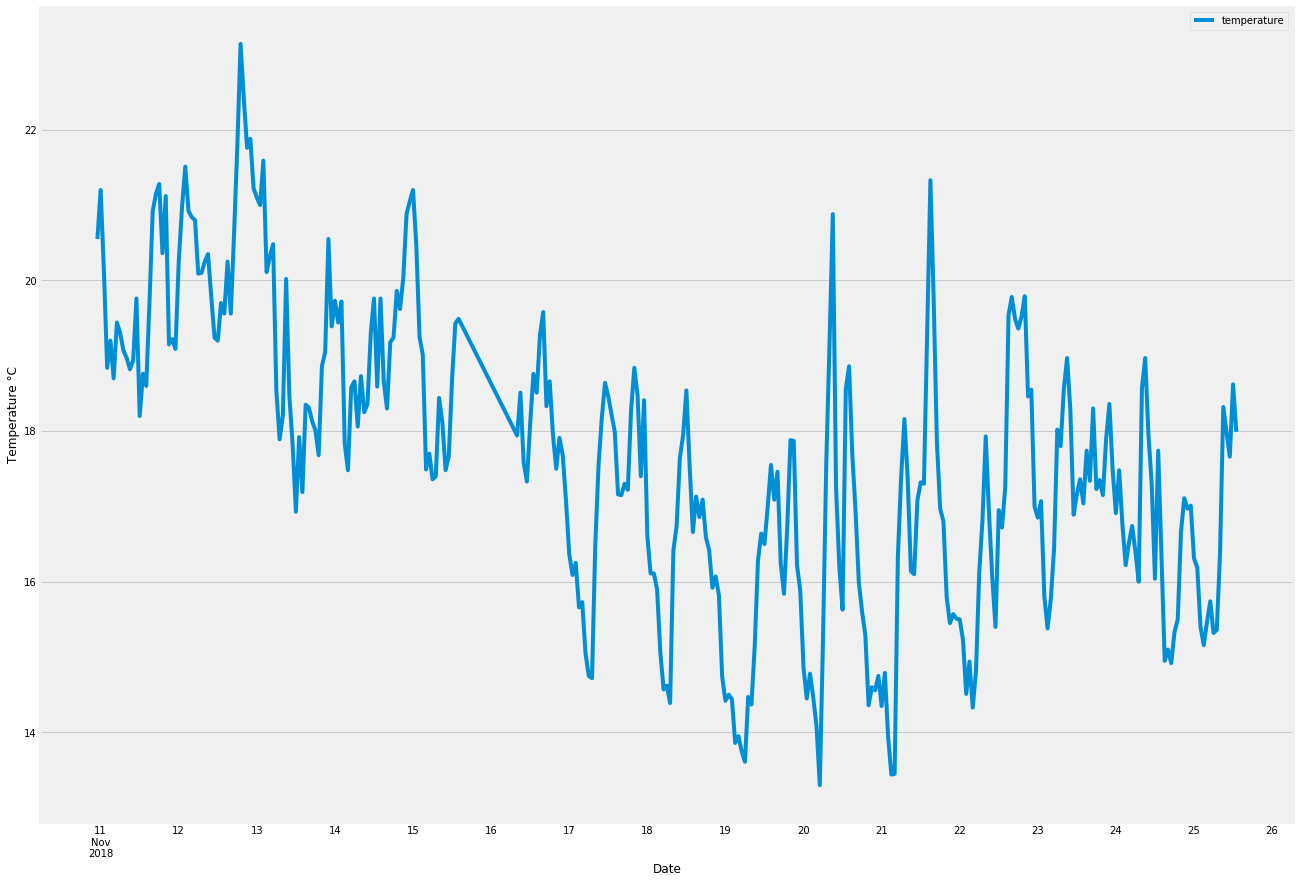

In [6]:
err = df.plot(figsize=(20, 15))

err.set_xlabel('Date')
err.set_ylabel('Temperature °C')

plt.legend()
plt.show()

As we can see there is a bit of a repeating pattern. First the temperature rises stays high for a little bit and than it plummits and repeat.

We are also curious what temperature levels occurs the most often. We can have a look at that by plotting out the data in the form of a bar chart.

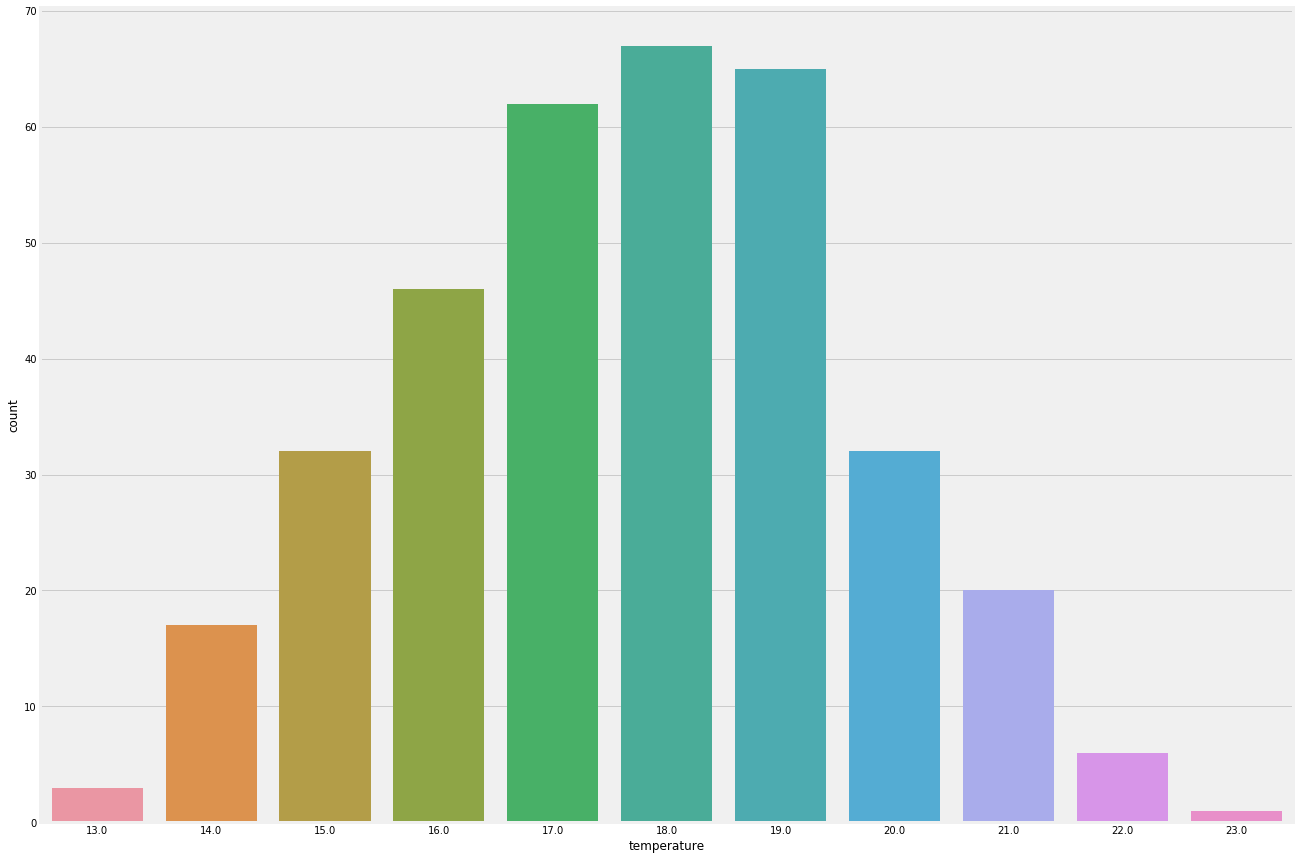

In [7]:
plt.figure(figsize=(20, 15))
sns.countplot(data['temperature'].round())
plt.show()

The temperature seems to linger mostly around ~17°C - ~19°C.

### a. Test Stationary <a name="stationary"></a>

Next we will check if our data is stationary. From the above line chart is is visible that this data is not stationary. However for completeness sake we will do a test.

#### Using the Dickey-Fuller test

A formal way of testing stationarity of a dataset is by plotting the moving average or moving variance and see if the series mean and variance varies with time. This approach will be handled by the ```TestStationaryPlot()``` method. The second way to test stationarity is to use the statistical test (the Dickey-Fuller Test). The null hypothesis for the test is that the time series is non-stationary. The test results compare a Test Statistic and Critical Values (cutoff value) at different confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. This technique will be handled by the ```TestStationaryAdfuller()``` method given below.

In [8]:
def TestStationaryPlot(ts):
    plt.figure(figsize=(20, 15))
    
    rol_mean = ts.rolling(window = 12, center = False).mean()
    rol_std = ts.rolling(window = 12, center = False).std()
    
    plt.plot(ts, color = 'blue',label = 'Original Data')
    plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std, color ='black', label = 'Rolling Std')
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25)
    
    plt.xlabel('Date', fontsize = 25)
    plt.ylabel('Temperature °C', fontsize = 25)
    plt.legend(loc='best', fontsize = 25)
    plt.title('Rolling Mean & Standard Deviation', fontsize = 25)
    plt.show(block= True)

In [9]:
def TestStationaryAdfuller(ts, cutoff = 0.01):
    ts_test = adfuller(ts.iloc[:, 0].values, autolag = 'AIC')
    ts_test_output = pd.Series(ts_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in ts_test[4].items():
        ts_test_output['Critical Value (%s)'%key] = value
    print(ts_test_output)
    
    if ts_test[1] <= cutoff:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

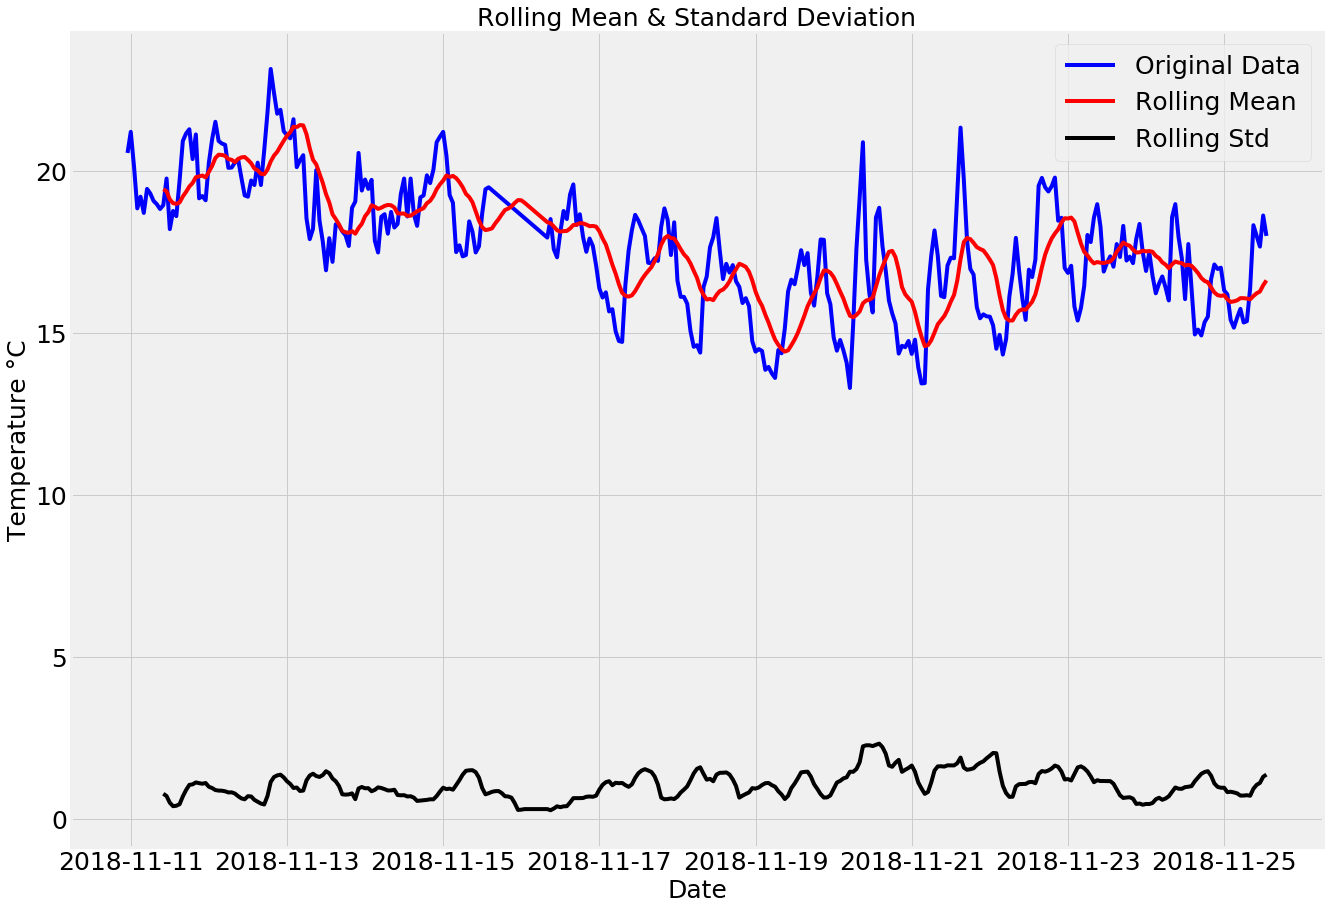

In [10]:
TestStationaryPlot(df)

In [11]:
TestStationaryAdfuller(df)

Test Statistic                  -2.142092
p-value                          0.227930
#Lags Used                      14.000000
Number of Observations Used    336.000000
Critical Value (1%)             -3.449963
Critical Value (5%)             -2.870181
Critical Value (10%)            -2.571373
dtype: float64
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


The emissions mean and the variation in standard deviation (black line) clearly vary with time. This shows that the series has a trend. So, it is not a stationary. Also, the Test Statistic is greater than the critical values with 90%, 95% and 99% confidence levels. Hence, no evidence to reject the null hypothesis. Therefore the series is nonstationary.

### b. Plotting the ACF and PACF <a name="acf-pacf">

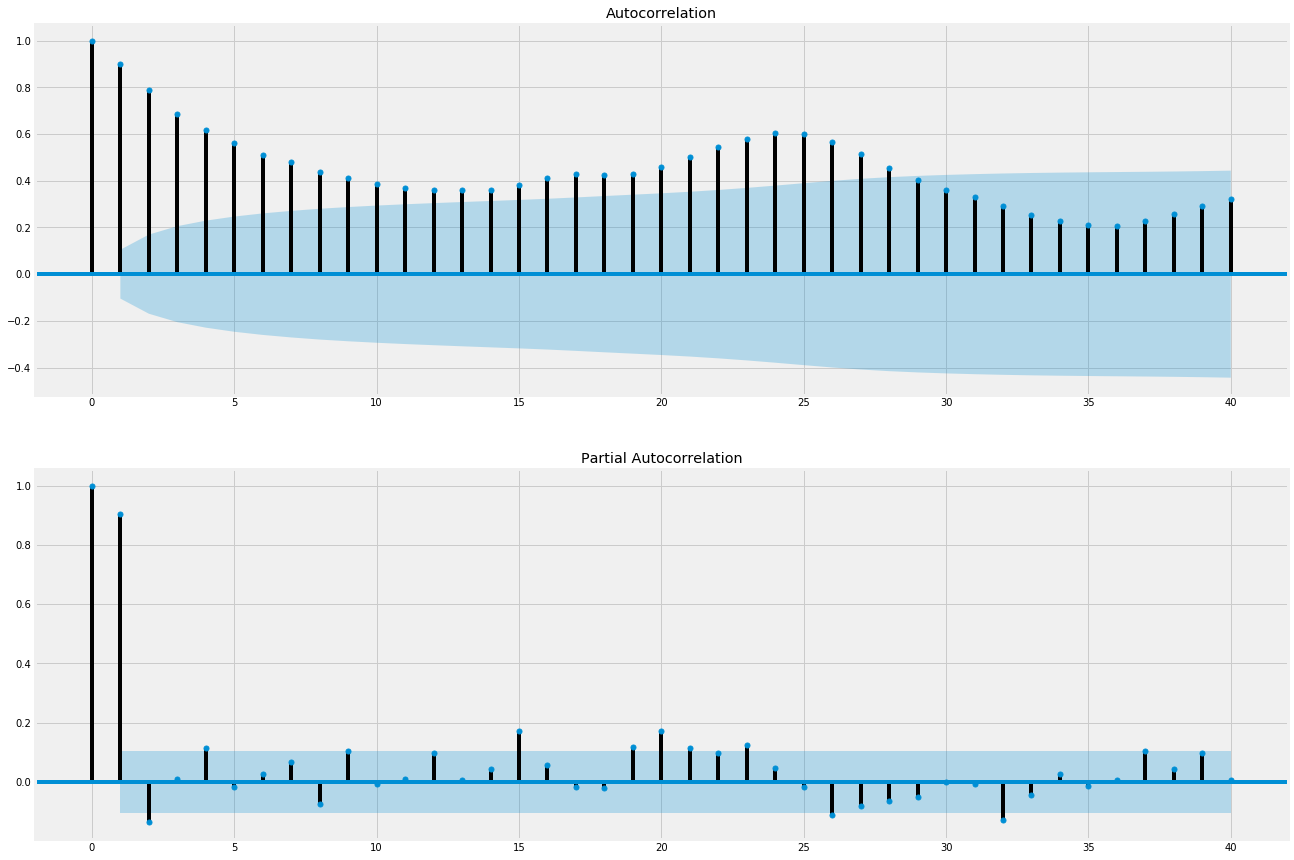

In [12]:
fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(211)
fig = plot_acf(df, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df, lags=40, ax=ax2)

Now we have taken a bit of a closer look at our data we can continue to the next notebook  where we will calculate the optimal parameters for our model.

**[⬆ back to top](#table-of-contents)** <br>
[next notebook](./4_model_selection.ipynb)